# 3. Pre-processing and Modelling

## Overview<a class="anchor" id="overview"></a>
---
This section will pre-process and model using the cleaned datasets. Estimators selected for modelling are Multinomial Naive Bayes and Logistic Regression. <br/>

## Table of Contents <a class="anchor" id="toc"></a>
---

* [Overview](#overview)
* [Importing Libraries](#importinglibraries)
* [Creating Custom Functions](#customfunctions)
* [Pre-processing for Modelling](#preprocessing)
* [Modelling & Evaluation](#modelevaluation)
    * [Naive Bayes](#naivebayes)
        * [Model NB_1.1](#nb_1.1)
        * [Model NB_1.2](#nb_1.2)
        * [Model NB_1.3](#nb_1.3)
        * [Model NB_1.4](#nb_1.4)
        * [Summary](#nb_summary)
    * [Logistic Regression](#logreg)
        * [Model LR_2.1](#lr_2.1)
        * [Model LR_2.2](#lr_2.2)
        * [Model LR_2.3](#lr_2.3)
        * [Model LR_2.4](#lr_2.4)
        * [Summary](#lr_summary)
    * [Comparison of scores across all models](#comparison)
* [Conclusions & Future Development](#conclusions)

## Importing Libraries <a class="anchor" id="importinglibraries"></a>
---
[Back to top!](#toc)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Custom Functions <a class="anchor" id="customfunctions"></a>
---
[Back to top!](#toc)

In [3]:
def get_scores(model_name, pipeline):
    print(model_name)
    print('------------')
    train_score = pipeline.score(X_train, y_train)
    print(f'Training score: {round(train_score, 4)}')
    test_score = pipeline.score(X_test, y_test)
    print(f'Testing score: {round(test_score, 4)}')

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def get_evaluation_metrics(model_name, cm, preds):
    print(model_name)
    print('------------')
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print()
    
    # accuracy = (tn + tp) / (tn + fp + fn + tp) 
    accuracy = accuracy_score(y_test, preds) 
    print(f'Accuracy: {round(accuracy, 4)}')
    
    specificity = tn / (tn + fp)
    print(f'Specificity: {round(specificity, 4)}')
    
    # sensitivity = tp / (tp + fn)
    sensitivity = recall_score(y_test, preds)
    print(f'Sensitivity: {round(sensitivity, 4)}')
    
    # precision = tp / (tp + fp)
    precision = precision_score(y_test, preds)
    print(f'Precision: {round(precision, 4)}')
    
    # f1score = 2 * (precision*sensitivity) / (precision + sensitivity)
    f1score = f1_score(y_test, preds)
    print(f'F1 score: {round(f1score, 4)}')
    
    roc_auc = roc_auc_score(y_test, preds)
    print(f'ROC AUC score: {round(roc_auc, 4)}')

In [5]:
def get_gs_metrics(model_name, gs_model):
    print(model_name)
    print('------------')
    # best params
    best_params = gs_model.best_params_
    print(f"Best Parameters: {best_params}")
    # best score
    best_score = gs_model.best_score_
    print(f"Best train score: {round(best_score, 4)}")

## Pre-processing for Modelling <a class="anchor" id="preprocessing"></a>
---
[Back to top!](#toc)

In [6]:
satire = pd.read_csv('../data/modelling_dataset.csv')
satire.head()

,title,subreddit
0,Representative Wants To Meet More Kids Online,TheOnion
1,Minnesota Deploys National Guard Ahead Of Next...,TheOnion
2,Small Kindnesses: Gamer Shields Ailing Grandmo...,TheOnion
3,Report: San Diegans Just Assumed Padres Were I...,TheOnion
4,Colorado Temporarily Re-Bans Marijuana For Sta...,TheOnion


In [7]:
satire['subreddit'] = satire['subreddit'].map({'TheOnion': 1, 'worldnews': 0})
satire.head()

,title,subreddit
0,Representative Wants To Meet More Kids Online,1
1,Minnesota Deploys National Guard Ahead Of Next...,1
2,Small Kindnesses: Gamer Shields Ailing Grandmo...,1
3,Report: San Diegans Just Assumed Padres Were I...,1
4,Colorado Temporarily Re-Bans Marijuana For Sta...,1


In [8]:
satire.tail()

,title,subreddit
4199,"Tim Hortons, Metro among retailers in new repo...",0
4200,Covid Philippines: Man dies after being forced...,0
4201,Lightning strikes will more than double in Arc...,0
4202,"As it battles its worst drought in 56 years, T...",0
4203,Iran indicts 10 officials over shootdown of Uk...,0


In [9]:
X = satire['title']
y = satire['subreddit']

In [10]:
# checking balance of classes
y.value_counts(normalize=True)

1    0.556851
0    0.443149
Name: subreddit, dtype: float64

In [11]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
# baseline accuracy
y_test.value_counts(normalize=True)

1    0.5804
0    0.4196
Name: subreddit, dtype: float64

In [63]:
# list of dict
dict_null = [{'Model': 'Null Model', 
            'cvec': 0, 'tvec': 0, 'gs': 0,
            'Train Score': np.nan, 
            'Test Score': 0.5804,
            'Precision': np.nan, 
            'Specificity': np.nan,
            'Recall': np.nan,
            'F1 Score': np.nan, 
            'ROC AUC Score': np.nan}
           ]

df_null = pd.DataFrame(dict_null)
df_null

,Model,cvec,tvec,gs,Train Score,Test Score,Precision,Specificity,Recall,F1 Score,ROC AUC Score
0,Null Model,0,0,0,NaN,0.5804,NaN,NaN,NaN,NaN,NaN


## Modelling & Evaluation <a class="anchor" id="modelevaluation"></a>
---
[Back to top!](#toc)

The modelling workflow will be as such:
1. Using a transformer of choice (in this case Count Vectorizer then TD-IDF Vectorizer) to transform the dataframe
2. Using an estimator of choice (in this case Multinomial Naive Bayes then Logistic Regression) to train the model
3. Evaluate the model based on metrics such as `Train Score`, `Test Score`, `Precision`, `Specificity`, `Recall`, `ROC AUC Score` and the confusion matrix.
4. Using GridSearchCV to find the best hyperparameters for fine-tuning the model.

### Multinomial Naïve Bayes <a class="anchor" id="naivebayes"></a>
---
[Back to top!](#toc)

A total of 4 models will be trained using Multinomial Naive Bayes as an estimator:
* Model NB_1.1 - Using CountVectorizer and Multinomial Naive Bayes
* Model NB_1.2 - Optimizing Model NB_1.1 using GridSearchCV
* Model NB_1.3 - Using TF-IDF Vectorizer and Multinomial Naive Bayes
* Model NB_1.4 - Optimizing Model_1.3 using GridSearchCV

#### Model NB_1.1 - Using CountVectorizer and Multinomial Naive Bayes <a class="anchor" id="nb_1.1"></a>
[Back to top!](#toc)

In [15]:
# redefining training and testing sets with same random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Setting up pipeline for model 1.1
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe_11 = Pipeline([
    ('cvec', CountVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
    ('nb', MultinomialNB())
])

# Fitting the pipeline
pipe_11.fit(X_train, y_train)
pipe_11.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
  ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(stop_words=('english', 'onion', 'topical', 'ho')),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': ('english', 'onion', 'topical', 'ho'),
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [16]:
get_scores('Model NB_1.1', pipe_11)

# keeping variable for summary input later
train_score_11 = pipe_11.score(X_train, y_train)

Model NB_1.1
------------
Training score: 0.9772
Testing score: 0.9039


Model NB_1.1
------------
True Negatives: 400
False Positives: 41
False Negatives: 60
True Positives: 550

Accuracy: 0.9039
Specificity: 0.907
Sensitivity: 0.9016
Precision: 0.9306
F1 score: 0.9159
ROC AUC score: 0.9043


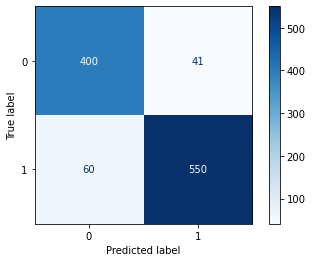

In [17]:
# Get predictions
preds_11 = pipe_11.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_11).ravel()
cm_11 = tn, fp, fn, tp 
get_evaluation_metrics('Model NB_1.1', cm_11, preds_11)

# keeping variable for summary input later
spec_11 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(pipe_11, X_test, y_test, cmap='Blues', values_format='d');

#### Model NB_1.2 - Optimizing Model NB_1.1 using GridSearchCV <a class="anchor" id="nb_1.2"></a>
[Back to top!](#toc)

In [18]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [19]:
# Instantiate GridSearchCV.
cvec_gs = GridSearchCV(pipe_11, # what object are we optimizing?
                       param_grid=pipe_params, # what parameters values are we searching?
                       cv=5) # 5-fold cross-validation.

# Fit GridSearch to training data.
cvec_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=('english',
                                                                    'onion',
                                                                    'topical',
                                                                    'ho'))),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [20]:
get_gs_metrics('Model NB_1.2', cvec_gs)

Model NB_1.2
------------
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Best train score: 0.901


In [21]:
get_scores('Model NB_1.2', cvec_gs)

# keeping variable for summary input later
train_score_12 = cvec_gs.score(X_train, y_train)

Model NB_1.2
------------
Training score: 0.9588
Testing score: 0.8906


Model NB_1.2
------------
True Negatives: 394
False Positives: 47
False Negatives: 68
True Positives: 542

Accuracy: 0.8906
Specificity: 0.8934
Sensitivity: 0.8885
Precision: 0.9202
F1 score: 0.9041
ROC AUC score: 0.891


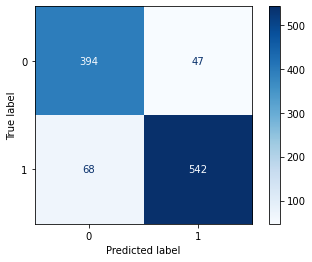

In [22]:
# Get predictions
preds_12 = cvec_gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_12).ravel()
cm_12 = tn, fp, fn, tp 
get_evaluation_metrics('Model NB_1.2', cm_12, preds_12)

# keeping variable for summary input later
spec_12 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(cvec_gs, X_test, y_test, cmap='Blues', values_format='d');

#### Model NB_1.3 - Using TF-IDF Vectorizer and Multinomial Naive Bayes <a class="anchor" id="nb_1.3"></a>
[Back to top!](#toc)

In [23]:
# redefining training and testing sets with same random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Setting up pipeline for model 1.3
# 1. TD-IDF Vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe_13 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
    ('nb', MultinomialNB())
])

# Fitting the pipeline
pipe_13.fit(X_train, y_train)
pipe_13.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
  ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(stop_words=('english', 'onion', 'topical', 'ho')),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': ('english', 'onion', 'topical', 'ho'),
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [24]:
get_scores('Model NB_1.3', pipe_13)

# keeping variable for summary input later
train_score_13 = pipe_13.score(X_train, y_train)

Model NB_1.3
------------
Training score: 0.9753
Testing score: 0.8991


Model NB_1.3
------------
True Negatives: 380
False Positives: 61
False Negatives: 45
True Positives: 565

Accuracy: 0.8991
Specificity: 0.8617
Sensitivity: 0.9262
Precision: 0.9026
F1 score: 0.9142
ROC AUC score: 0.894


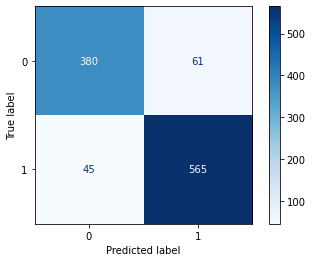

In [25]:
# Get predictions
preds_13 = pipe_13.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_13).ravel()
cm_13 = tn, fp, fn, tp 
get_evaluation_metrics('Model NB_1.3', cm_13, preds_13)

# keeping variable for summary input later
spec_13 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(pipe_13, X_test, y_test, cmap='Blues', values_format='d');

#### Model NB_1.4 - Optimizing Model_1.3 using GridSearchCV <a class="anchor" id="nb_1.4"></a>
[Back to top!](#toc)

In [26]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [27]:
# Instantiate GridSearchCV.
tvec_gs = GridSearchCV(pipe_13, # what object are we optimizing?
                       param_grid=pipe_params, # what parameters values are we searching?
                       cv=5) # 5-fold cross-validation.

# Fit GridSearch to training data.
tvec_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=('english',
                                                                    'onion',
                                                                    'topical',
                                                                    'ho'))),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [28]:
get_gs_metrics('Model NB_1.4', tvec_gs)

Model NB_1.4
------------
Best Parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Best train score: 0.8972


In [29]:
get_scores('Model NB_1.4', tvec_gs)

# keeping variable for summary input later
train_score_14 = tvec_gs.score(X_train, y_train)

Model NB_1.4
------------
Training score: 0.9597
Testing score: 0.8896


Model NB_1.4
------------
True Negatives: 373
False Positives: 68
False Negatives: 48
True Positives: 562

Accuracy: 0.8896
Specificity: 0.8458
Sensitivity: 0.9213
Precision: 0.8921
F1 score: 0.9065
ROC AUC score: 0.8836


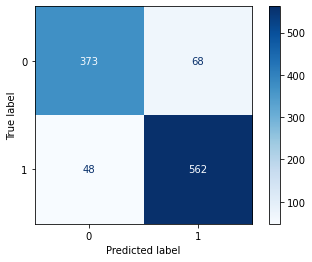

In [30]:
# Get predictions
preds_14 = tvec_gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_14).ravel()
cm_14 = tn, fp, fn, tp 
get_evaluation_metrics('Model NB_1.4', cm_14, preds_14)

# keeping variable for summary input later
spec_14 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(tvec_gs, X_test, y_test, cmap='Blues', values_format='d');

#### Summary & Evaluation for Naive Bayes Modelling <a class="anchor" id="nb_summary"></a>
[Back to top!](#toc)

In [31]:
# list of dict
dict_nb = [{'Model': 'NB_1.1', 
            'cvec': 1, 'tvec': 0, 'gs': 0,
            'Train Score': train_score_11, 
            'Test Score': accuracy_score(y_test, preds_11),
            'Precision': precision_score(y_test, preds_11), 
            'Specificity': spec_11,
            'Recall': recall_score(y_test, preds_11),
            'F1 Score': f1_score(y_test, preds_11), 
            'ROC AUC Score': roc_auc_score(y_test, preds_11),},
           {'Model': 'NB_1.2', 
            'cvec': 1, 'tvec': 0, 'gs': 1,
            'Train Score': train_score_12, 
            'Test Score': accuracy_score(y_test, preds_13),
            'Precision': precision_score(y_test, preds_13), 
            'Specificity': spec_12,
            'Recall': recall_score(y_test, preds_13),
            'F1 Score': f1_score(y_test, preds_13), 
            'ROC AUC Score': roc_auc_score(y_test, preds_13),},
           {'Model': 'NB_1.3', 
            'cvec': 0, 'tvec': 1, 'gs': 0,
            'Train Score': train_score_13, 
            'Test Score': accuracy_score(y_test, preds_13),
            'Precision': precision_score(y_test, preds_13), 
            'Specificity': spec_13,
            'Recall': recall_score(y_test, preds_13),
            'F1 Score': f1_score(y_test, preds_13), 
            'ROC AUC Score': roc_auc_score(y_test, preds_13),},
           {'Model': 'NB_1.4', 
            'cvec': 0, 'tvec': 1, 'gs': 1,
            'Train Score': train_score_14, 
            'Test Score': accuracy_score(y_test, preds_14),
            'Precision': precision_score(y_test, preds_14), 
            'Specificity': spec_14,
            'Recall': recall_score(y_test, preds_14),
            'F1 Score': f1_score(y_test, preds_14), 
            'ROC AUC Score': roc_auc_score(y_test, preds_14),}
           ]

In [32]:
df_nb = pd.DataFrame(dict_nb)
df_nb.round(4) # rounding off values to 4 decimal places

,Model,cvec,tvec,gs,Train Score,Test Score,Precision,Specificity,Recall,F1 Score,ROC AUC Score
0,NB_1.1,1,0,0,0.9772,0.9039,0.9306,0.9070,0.9016,0.9159,0.9043
1,NB_1.2,1,0,1,0.9588,0.8991,0.9026,0.8934,0.9262,0.9142,0.8940
2,NB_1.3,0,1,0,0.9753,0.8991,0.9026,0.8617,0.9262,0.9142,0.8940
3,NB_1.4,0,1,1,0.9597,0.8896,0.8921,0.8458,0.9213,0.9065,0.8836


#### General Observations for using Multinomial Naive Bayes as the Satirical News Classification Model
* All models tend to be overfitted to the training set.
* Using Count Vectorizer as a transformer generally yields better scores as compared to using TD-IDF Vectorizer with some exceptions e.g. `Recall`
* NB_1.2 and NB_1.3 has the highest `Recall` scores, meaning that the chances of getting false negatives are lower compared to the other two models.

## Logistic Regression <a class="anchor" id="logreg"></a>
---
[Back to top!](#toc)

A total of 4 models will be trained using Logistic Regression as an estimator:
* Model LR_2.1 - Using CountVectorizer and Logistic Regression
* Model LR_2.2 - Optimizing Model LR_2.1 using GridSearchCV
* Model LR_2.3 - Using TF-IDF Vectorizer and Logistic Regression
* Model LR_2.4 - Optimizing Model LR_2.3 using GridSearchCV

#### Model LR_2.1 - Using CountVectorizer and Logistic Regression <a class="anchor" id="lr_2.1"></a>
[Back to top!](#toc)

In [37]:
# redefining training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Setting up pipeline for model 2.1
# 1. CountVectorizer (transformer)
# 2. Logistic Regression (estimator)
pipe_21 = Pipeline([
    ('cvec', CountVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
    ('lr', LogisticRegression())
])

# Fitting the pipeline
pipe_21.fit(X_train, y_train)
pipe_21.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
  ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(stop_words=('english', 'onion', 'topical', 'ho')),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': ('english', 'onion', 'topical', 'ho'),
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__pena

In [38]:
get_scores('Model LR_2.1', pipe_21)

# keeping variable for summary input later
train_score_21 = pipe_21.score(X_train, y_train)

Model LR_2.1
------------
Training score: 0.9965
Testing score: 0.9049


Model LR_2.1
------------
True Negatives: 377
False Positives: 64
False Negatives: 36
True Positives: 574

Accuracy: 0.9049
Specificity: 0.8549
Sensitivity: 0.941
Precision: 0.8997
F1 score: 0.9199
ROC AUC score: 0.8979


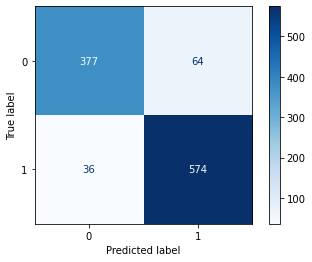

In [39]:
# Get predictions
preds_21 = pipe_21.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_21).ravel()
cm_21 = tn, fp, fn, tp 
get_evaluation_metrics('Model LR_2.1', cm_21, preds_21)

# keeping variable for summary input later
spec_21 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(pipe_21, X_test, y_test, cmap='Blues', values_format='d');

#### Model LR_2.2 - Optimizing Model LR_2.1 using GridSearchCV  <a class="anchor" id="lr_2.2"></a>
[Back to top!](#toc)

In [40]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [41]:
# Instantiate GridSearchCV.
cvec_gs = GridSearchCV(pipe_21, # what object are we optimizing?
                       param_grid=pipe_params, # what parameters values are we searching?
                       cv=5) # 5-fold cross-validation.

# Fit GridSearch to training data.
cvec_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=('english',
                                                                    'onion',
                                                                    'topical',
                                                                    'ho'))),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [42]:
get_gs_metrics('Model LR_2.2', cvec_gs)

Model LR_2.2
------------
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Best train score: 0.89


In [43]:
get_scores('Model LR_2.2', cvec_gs)

# keeping variable for summary input later
train_score_22 = cvec_gs.score(X_train, y_train)

Model LR_2.2
------------
Training score: 0.9899
Testing score: 0.8991


Model LR_2.2
------------
True Negatives: 376
False Positives: 65
False Negatives: 41
True Positives: 569

Accuracy: 0.8991
Specificity: 0.8526
Sensitivity: 0.9328
Precision: 0.8975
F1 score: 0.9148
ROC AUC score: 0.8927


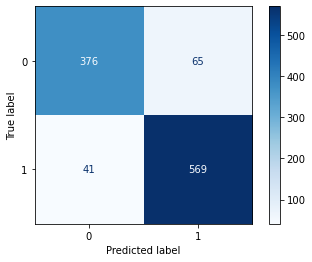

In [44]:
# Get predictions
preds_22 = cvec_gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_22).ravel()
cm_22 = tn, fp, fn, tp 
get_evaluation_metrics('Model LR_2.2', cm_22, preds_22)

# keeping variable for summary input later
spec_22 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(cvec_gs, X_test, y_test, cmap='Blues', values_format='d');

#### Model LR_2.3 - Using TF-IDF Vectorizer and Logistic Regression <a class="anchor" id="lr_2.3"></a>
[Back to top!](#toc)

In [45]:
# redefining training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Setting up pipeline for model 2.1
# 1. TF-IDF Vectorizer (transformer)
# 2. Logistic Regression (estimator)
pipe_23 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
    ('lr', LogisticRegression())
])

# Fitting the pipeline
pipe_23.fit(X_train, y_train)
pipe_23.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(stop_words=('english', 'onion', 'topical', 'ho'))),
  ('lr', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(stop_words=('english', 'onion', 'topical', 'ho')),
 'lr': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': ('english', 'onion', 'topical', 'ho'),
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,


In [46]:
get_scores('Model LR_2.3', pipe_23)

# keeping variable for summary input later
train_score_23 = pipe_23.score(X_train, y_train)

Model LR_2.3
------------
Training score: 0.9623
Testing score: 0.8915


Model LR_2.3
------------
True Negatives: 353
False Positives: 88
False Negatives: 26
True Positives: 584

Accuracy: 0.8915
Specificity: 0.8005
Sensitivity: 0.9574
Precision: 0.869
F1 score: 0.9111
ROC AUC score: 0.8789


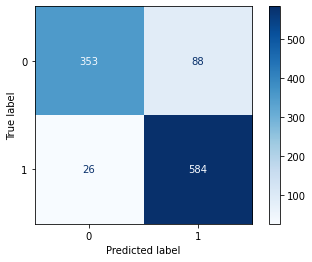

In [47]:
# Get predictions
preds_23 = pipe_23.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_23).ravel()
cm_23 = tn, fp, fn, tp 
get_evaluation_metrics('Model LR_2.3', cm_23, preds_23)

# keeping variable for summary input later
spec_23 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(pipe_23, X_test, y_test, cmap='Blues', values_format='d');

#### Model LR_2.4 - Optimizing Model LR_2.3 using GridSearchCV <a class="anchor" id="lr_2.4"></a>
[Back to top!](#toc)

In [48]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [49]:
# Instantiate GridSearchCV.
tvec_gs = GridSearchCV(pipe_23, # what object are we optimizing?
                       param_grid=pipe_params, # what parameters values are we searching?
                       cv=5) # 5-fold cross-validation.

# Fit GridSearch to training data.
tvec_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=('english',
                                                                    'onion',
                                                                    'topical',
                                                                    'ho'))),
                                       ('lr', LogisticRegression())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [50]:
get_gs_metrics('Model LR_2.4', tvec_gs)

Model LR_2.4
------------
Best Parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Best train score: 0.8877


In [51]:
get_scores('Model LR_2.4', tvec_gs)

# keeping variable for summary input later
train_score_24 = tvec_gs.score(X_train, y_train)

Model LR_2.4
------------
Training score: 0.9559
Testing score: 0.8868


Model LR_2.4
------------
True Negatives: 357
False Positives: 84
False Negatives: 35
True Positives: 575

Accuracy: 0.8868
Specificity: 0.8095
Sensitivity: 0.9426
Precision: 0.8725
F1 score: 0.9062
ROC AUC score: 0.8761


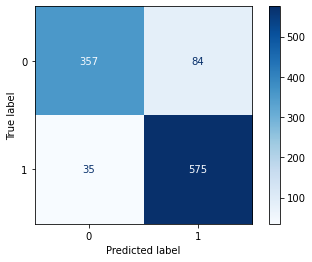

In [52]:
# Get predictions
preds_24 = tvec_gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_24).ravel()
cm_24 = tn, fp, fn, tp 
get_evaluation_metrics('Model LR_2.4', cm_24, preds_24)

# keeping variable for summary input later
spec_24 = tn / (tn + fp)

# visualizing confusion matrix
plot_confusion_matrix(tvec_gs, X_test, y_test, cmap='Blues', values_format='d');

#### Summary & Evaluation for Logistic Regression Modelling <a class="anchor" id="lr_summary"></a>
[Back to top!](#toc)

In [53]:
# list of dict
dict_lr = [{'Model': 'LR_2.1', 
            'cvec': 1, 'tvec': 0, 'gs': 0,
            'Train Score': train_score_21, 
            'Test Score': accuracy_score(y_test, preds_21),
            'Precision': precision_score(y_test, preds_21), 
            'Specificity': spec_21,
            'Recall': recall_score(y_test, preds_21),
            'F1 Score': f1_score(y_test, preds_21), 
            'ROC AUC Score': roc_auc_score(y_test, preds_21),},
           {'Model': 'LR_2.2', 
            'cvec': 1, 'tvec': 0, 'gs': 1,
            'Train Score': train_score_22, 
            'Test Score': accuracy_score(y_test, preds_22),
            'Precision': precision_score(y_test, preds_22), 
            'Specificity': spec_22,
            'Recall': recall_score(y_test, preds_22),
            'F1 Score': f1_score(y_test, preds_22), 
            'ROC AUC Score': roc_auc_score(y_test, preds_22),},
           {'Model': 'LR_2.3', 
            'cvec': 0, 'tvec': 1, 'gs': 0,
            'Train Score': train_score_23, 
            'Test Score': accuracy_score(y_test, preds_23),
            'Precision': precision_score(y_test, preds_23), 
            'Specificity': spec_23,
            'Recall': recall_score(y_test, preds_23),
            'F1 Score': f1_score(y_test, preds_23), 
            'ROC AUC Score': roc_auc_score(y_test, preds_23),},
           {'Model': 'LR_2.4', 
            'cvec': 0, 'tvec': 1, 'gs': 1,
            'Train Score': train_score_24, 
            'Test Score': accuracy_score(y_test, preds_24),
            'Precision': precision_score(y_test, preds_24), 
            'Specificity': spec_24,
            'Recall': recall_score(y_test, preds_24),
            'F1 Score': f1_score(y_test, preds_24), 
            'ROC AUC Score': roc_auc_score(y_test, preds_24),}
           ]

In [54]:
df_lr = pd.DataFrame(dict_lr)
df_lr.round(4) # rounding off values to 4 decimal places

,Model,cvec,tvec,gs,Train Score,Test Score,Precision,Specificity,Recall,F1 Score,ROC AUC Score
0,LR_2.1,1,0,0,0.9965,0.9049,0.8997,0.8549,0.9410,0.9199,0.8979
1,LR_2.2,1,0,1,0.9899,0.8991,0.8975,0.8526,0.9328,0.9148,0.8927
2,LR_2.3,0,1,0,0.9623,0.8915,0.8690,0.8005,0.9574,0.9111,0.8789
3,LR_2.4,0,1,1,0.9559,0.8868,0.8725,0.8095,0.9426,0.9062,0.8761


#### General Observations for using Logistic Regression as the Satirical News Classification Model
* All models tend to be overfitted to the training set.
* Using Count Vectorizer as a transformer generally yields better scores as compared to using TD-IDF Vectorizer with some exceptions e.g. `Recall`
* LR_2.3 has the highest `Recall` score, meaning that the chances of getting false negatives are lower compared to the other three models.

In [55]:
# Evaluation and Conceptual Understanding

#     Does the student accurately identify and explain the baseline score?
#     Does the student select and use metrics relevant to the problem objective?
#     Does the student interpret the results of their model for purposes of inference?
#     Is domain knowledge demonstrated when interpreting results?
#     Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?


## Comparison of Scores across all Models <a class="anchor" id="comparison"></a>
---
[Back to top!](#toc)

In this case of a classification model where we are predicting posts that contains satirical news, we probably want to find some combination of sensitivity and Specificity. 
- Focusing only on sensitivity means we minimize false negatives. This means that there will be less news that we incorrectly predict as non-satire, but more news we incorrectly predict to be satire.
- Focusing only on specificity means we minimize false positives. This means that there will be less news that we incorrectly predict as satire, but more news we incorrectly predict to be non-satire.

Sensitivity and specificity are not equally important in this case though. Sensitivity is more important as it is better to tell people that non-satirical news are satire as compared to tell people that satirical news are not satire, reducing the chances of misinformation. 

While focusing on sensitivity, we must also not let specificity suffer too much. Lower specificity will result in the classification model telling us that most non-satirical news are satire, which might be unethical as it will mislead the masses to disbelieve news that may be true and relevant.

Hence, in this classification model, the evaluation metrics optimized will be:
1) `Recall`, as it's better than optimizing `Specificity`. <br/>
2) Try to optimize `F1 Score`, a combination of `Recall` and `Specificity`. This will ensure that our specificity does not suffer too much as we are optimizing sensitivity.

In [77]:
all_models = [df_null, df_nb, df_lr]
df_summary = pd.concat(all_models, ignore_index=True)

# to estimate the extent of overfitting of model to training set across all models
df_summary[['Difference']] = df_summary['Train Score'] - df_summary['Test Score']
df_summary.round(4).sort_values(by=['Recall'], ascending=False)
#df_summary.round(4)

,Model,cvec,tvec,gs,Train Score,Test Score,Precision,Specificity,Recall,F1 Score,ROC AUC Score,Difference
7,LR_2.3,0,1,0,0.9623,0.8915,0.8690,0.8005,0.9574,0.9111,0.8789,0.0707
8,LR_2.4,0,1,1,0.9559,0.8868,0.8725,0.8095,0.9426,0.9062,0.8761,0.0691
5,LR_2.1,1,0,0,0.9965,0.9049,0.8997,0.8549,0.9410,0.9199,0.8979,0.0917
6,LR_2.2,1,0,1,0.9899,0.8991,0.8975,0.8526,0.9328,0.9148,0.8927,0.0907
2,NB_1.2,1,0,1,0.9588,0.8991,0.9026,0.8934,0.9262,0.9142,0.8940,0.0596
3,NB_1.3,0,1,0,0.9753,0.8991,0.9026,0.8617,0.9262,0.9142,0.8940,0.0761
4,NB_1.4,0,1,1,0.9597,0.8896,0.8921,0.8458,0.9213,0.9065,0.8836,0.0701
1,NB_1.1,1,0,0,0.9772,0.9039,0.9306,0.9070,0.9016,0.9159,0.9043,0.0733
0,Null Model,0,0,0,NaN,0.5804,NaN,NaN,NaN,NaN,NaN,NaN


Looking across the scores of all classification models trained and tested:

* All other models fared better than the baseline model. 
* All models have the tendency of overfitting to the training data as seen from `Difference`, with the highest being LR_2.1 and lowest being NB_1.2. This means that NB_1.2 has the best ability to generalize to unseen data among all models.
* All the `Test Score` are in the same range of values (approximately 0.88 to 0.91).
* Models using Logistic Regression generally has better `Recall` scores compared to Multinomial Naive Bayes.
* LR_2.1 scored the highest for `Test Score` aka accuracy, but it is the most overfitted model among the others.
* LR_2.3 scored the highest for `Recall`, but has a lower `F1 Score` compared to the rest of the models. 
* LR_2.1 scored the highest for `F1 Score` while having a relatively high score for `Recall` among all models.
* While the `ROC AUC Score` is higher for LR_2.1 compared to LR_2.3, the difference is relatively small.

## Conclusions <a class="anchor" id="conclusions"></a>
---
[Back to top!](#toc)

### Recommendations for the Satirical News Classifier

LR_2.3 will be the most suitable model for this satirical news classifier based on the summary of scores shown above. It scores the best in `Recall`, which is the evaluation metric that should be optimized in order to reduce false negatives. The `F1 Score` is only slightly compromised (negligible difference of 0.0088) as a result of optimizing `Recall`, which is still within acceptable range. Similarly for `ROC AUC Score` where LR_2.3 scored the second lowest among all the other models, it is still within acceptable range.

Hence, I would recommend LR_2.3 to be used as the satirical news classification model.

### Future Development for the Satirical News Classification Model

1) Other classification models that can be trained and evaluated:
- K-Nearest Neighbours
- Decision Tree
- Bagged Decision Trees
- Random Forest
- Support Vector Regressor 
<br/>

2) Further hyperparameter tuning that can be done:
- Using RandomizedSearchCV instead of only GridSearchCV to explore higher numbers of different hyperparameters
<br/>

3) More in-depth model evaluation metrics that can be done:
- Optimizing a custom metric that weighs `Recall` somewhat more importantly than `Specificity`.
- Looking at my ROC curve and try to find a place where `Recall` is very high and 1 - `Specificity` is pretty low.

4) To further increase the business value of this project for the clients, instead of scraping only the posts of the subreddit to determine whether it is satirical news, this classification model can also scrape the contents of the linked articles to further determine whether it belongs to satire. This will not only increase the sensitivity of the model, but also ensure that the title of the post will not be able to mislead and by-pass the classification model if the linked article is actually a satire piece.